In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)
from sklearn.inspection import permutation_importance
import joblib

In [3]:
# Optional: If you have caas_jupyter_tools in the environment this displays nicer tables in some UIs
try:
    from caas_jupyter_tools import display_dataframe_to_user
    have_display = True
except Exception:
    have_display = False

In [5]:
# ---------- CONFIG ----------
DATA_PATH = '/mnt/data/diabetes.csv'   # change if needed
MODEL_OUTPUT_PATH = '/mnt/data/best_model.joblib'
RANDOM_STATE = 42

In [17]:
assert os.path.exists("diabetes.csv"), f"File not found: {"diabetes.csv"}"
df = pd.read_csv("diabetes.csv")
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

if have_display:
    display_dataframe_to_user("Dataset head (first 10 rows)", df.head(10))
else:
    print(df.head())

print("\nData summary:")
print(df.describe())

Loaded dataset shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Data summary:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000  

In [19]:
# ---------- 2) EDA ----------
print("\nMissing values (raw):")
print(df.isnull().sum())

# For Pima dataset style: treat zeros in certain columns as missing
zero_missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
present_zero_cols = [c for c in zero_missing_cols if c in df.columns]
print("Treating zero as missing for:", present_zero_cols)
for c in present_zero_cols:
    zcount = (df[c] == 0).sum()
    print(f"{c}: zeros={zcount} ({zcount/len(df):.2%})")


Missing values (raw):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Treating zero as missing for: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
Glucose: zeros=5 (0.65%)
BloodPressure: zeros=35 (4.56%)
SkinThickness: zeros=227 (29.56%)
Insulin: zeros=374 (48.70%)
BMI: zeros=11 (1.43%)


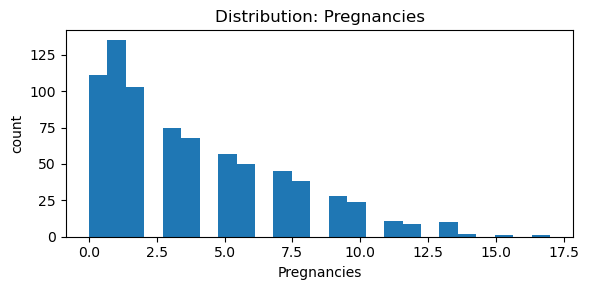

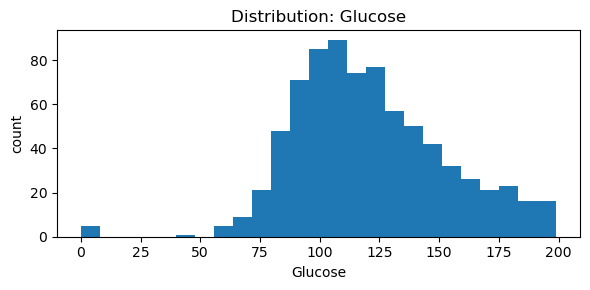

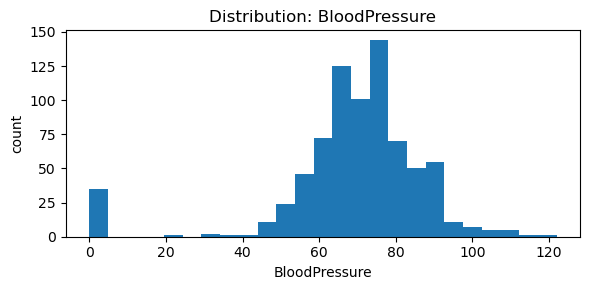

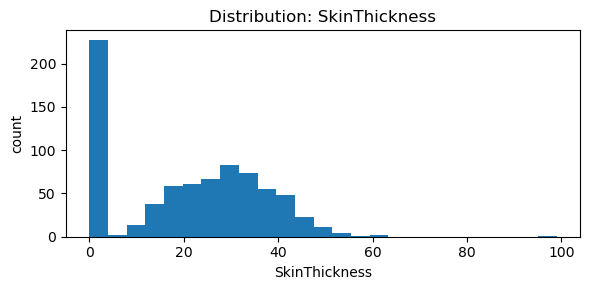

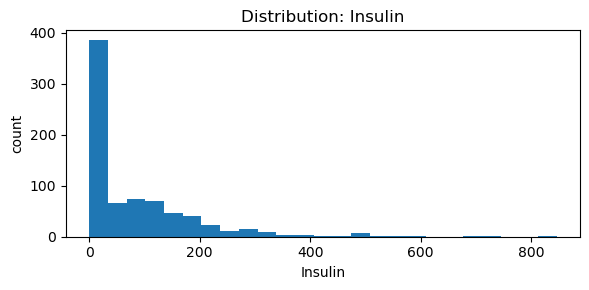

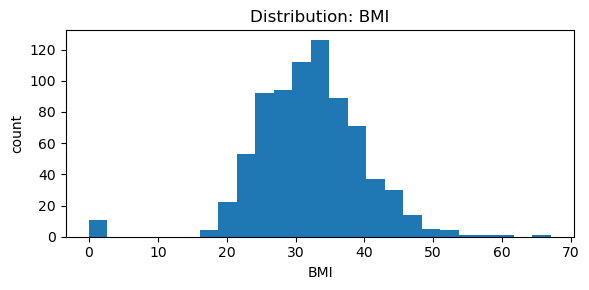

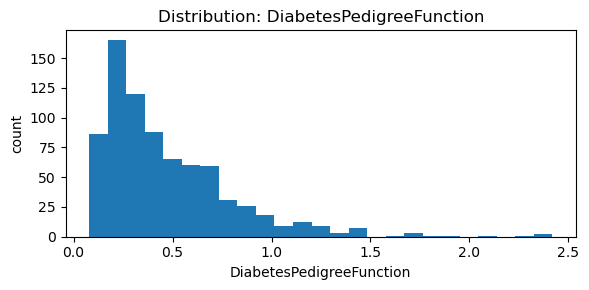

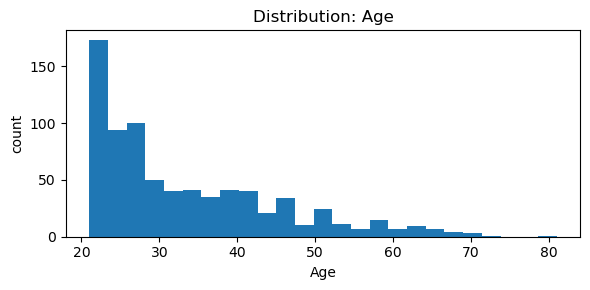

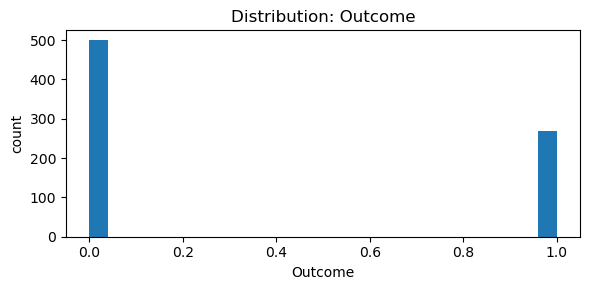

In [21]:
# Plot histograms (matplotlib only; one chart per figure)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=25)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

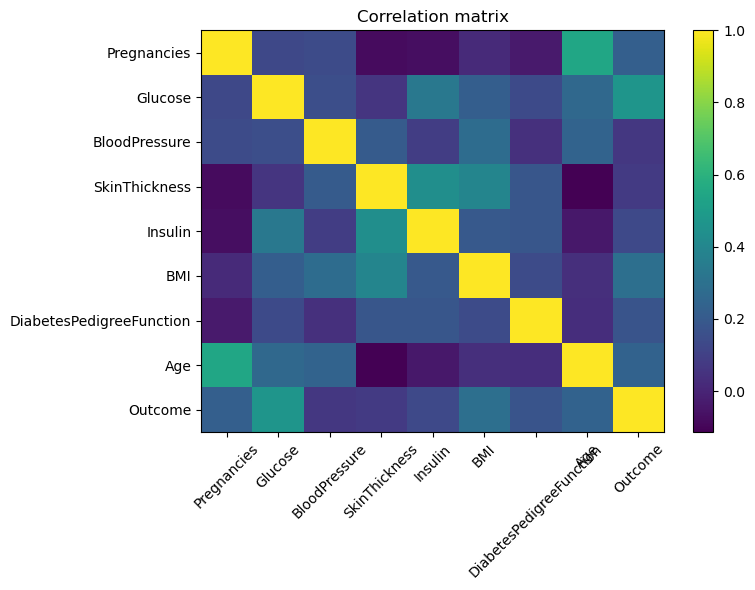

In [23]:
# Correlation heatmap (matplotlib imshow)
corr = df.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

In [25]:
# ---------- 3) Preprocessing ----------
df2 = df.copy()
# Replace zeros with NaN for the selected columns
for c in present_zero_cols:
    df2[c] = df2[c].replace(0, np.nan)

print("\nMissing after zero->NaN replacement:")
print(df2.isnull().sum())


Missing after zero->NaN replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [27]:
# Impute median for numeric features with missing values
imputer = SimpleImputer(strategy='median')
if len(present_zero_cols) > 0:
    df2[present_zero_cols] = imputer.fit_transform(df2[present_zero_cols])

print("Missing after imputation:")
print(df2.isnull().sum())

# Optional simple feature engineering: BMI category and Age group (if columns exist)
if 'BMI' in df2.columns:
    df2['BMI_category'] = pd.cut(df2['BMI'], bins=[0,18.5,25,30,100],
                                 labels=['Underweight','Normal','Overweight','Obese'])
if 'Age' in df2.columns:
    df2['Age_group'] = pd.cut(df2['Age'], bins=[20,30,40,50,60,100],
                              labels=['21-30','31-40','41-50','51-60','60+'])

Missing after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [29]:
# Choose target
target_col = 'Outcome' if 'Outcome' in df2.columns else df2.columns[-1]
X = df2.drop(columns=[target_col])
y = df2[target_col].astype(int)
print("\nTarget distribution:\n", y.value_counts())


Target distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


In [31]:
# Use only numeric features for baseline modelling (you can encode categorical engineered features later)
X_model = X.select_dtypes(include=[np.number]).copy()
print("Features used for modeling:", X_model.columns.tolist())


Features used for modeling: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [46]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2,
                                                    random_state=RANDOM_STATE, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (614, 8) Test shape: (154, 8)


In [48]:
# ---------- 4) Models & CV ----------
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

print("\nCross-validation (5-fold ROC AUC) on train set:")
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = scores.mean()
    print(f"{name}: mean ROC AUC = {scores.mean():.4f} ± {scores.std():.4f}")


Cross-validation (5-fold ROC AUC) on train set:
LogisticRegression: mean ROC AUC = 0.8432 ± 0.0293
RandomForest: mean ROC AUC = 0.8241 ± 0.0230
GradientBoosting: mean ROC AUC = 0.8021 ± 0.0275


In [50]:
# Fit each model and evaluate on test set
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    results[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }
    print(f"\n{name} Evaluation (test set):")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)


LogisticRegression Evaluation (test set):
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion Matrix:
 [[82 18]
 [27 27]]

RandomForest Evaluation (test set):
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154

Confusion Matrix:
 [[84 16]
 [24 30]]

GradientBoosting Evaluation (test set):
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.67      0.63      0

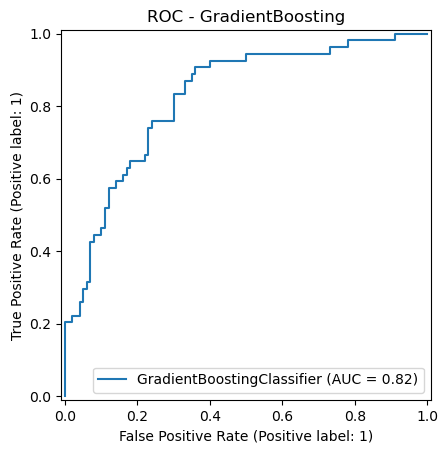

In [56]:
# ROC
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title(f'ROC - {name}')
plt.show()

In [58]:
# Choose best by ROC AUC on test
best_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
best_model = results[best_name]['model']
print(f"\nBest model on test set by ROC AUC: {best_name} (AUC = {results[best_name]['roc_auc']:.4f})")



Best model on test set by ROC AUC: GradientBoosting (AUC = 0.8246)


In [60]:
# ---------- 5) Quick RandomizedSearchCV for RandomForest (optional improvement) ----------
if 'RandomForest' in models:
    print("\nRunning RandomizedSearchCV for RandomForest (small search for demo)...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    rsearch = RandomizedSearchCV(rf, param_dist, n_iter=12, cv=3, scoring='roc_auc', random_state=RANDOM_STATE, n_jobs=-1)
    rsearch.fit(X_train_scaled, y_train)
    print("RandomForest best params:", rsearch.best_params_)
    rf_best = rsearch.best_estimator_
    y_proba_rf = rf_best.predict_proba(X_test_scaled)[:,1]
    print("RandomForest tuned ROC AUC on test:", roc_auc_score(y_test, y_proba_rf))


Running RandomizedSearchCV for RandomForest (small search for demo)...
RandomForest best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
RandomForest tuned ROC AUC on test: 0.8138888888888889


In [64]:
 # adopt tuned if better
if roc_auc_score(y_test, y_proba_rf) > results[best_name]['roc_auc']:
        best_name = "RandomForest_tuned"
        best_model = rf_best
        results[best_name] = {
            "model": rf_best,
            "accuracy": accuracy_score(y_test, rf_best.predict(X_test_scaled)),
            "precision": precision_score(y_test, rf_best.predict(X_test_scaled)),
            "recall": recall_score(y_test, rf_best.predict(X_test_scaled)),
            "f1": f1_score(y_test, rf_best.predict(X_test_scaled)),
            "roc_auc": roc_auc_score(y_test, y_proba_rf)
        }
        print("Updated best model to tuned RandomForest.")

print("Final selected model:", best_name)

Final selected model: GradientBoosting


SHAP not installed — will compute permutation importance. Install shap for richer XAI visuals: pip install shap
Computing permutation importance on test set...
                    feature  importance_mean  importance_std
0                   Glucose         0.057792        0.022391
1                       Age         0.043506        0.018454
2                       BMI         0.029870        0.019667
3               Pregnancies         0.017316        0.012129
4  DiabetesPedigreeFunction         0.015152        0.018238
5             BloodPressure         0.014069        0.012330
6                   Insulin         0.006061        0.017896
7             SkinThickness         0.004978        0.012623


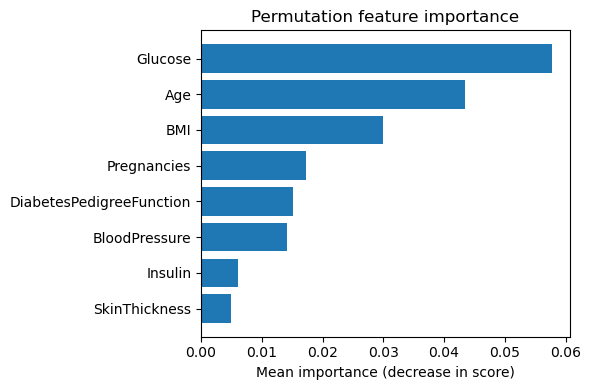

In [66]:
# ---------- 6) Explainable AI (XAI): SHAP preferred, else permutation importance ----------
use_shap = False
try:
    import shap
    use_shap = True
    print("SHAP is installed. We'll compute SHAP values for explainability.")
except Exception:
    print("SHAP not installed — will compute permutation importance. Install shap for richer XAI visuals: pip install shap")
    use_shap = False

feature_names = X_model.columns.tolist()

if use_shap:
    try:
        # If tree model, TreeExplainer is fast
        if best_name.lower().find("randomforest") != -1 or best_name.lower().find("gradient") != -1:
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_train_scaled)
            # shap returns list for binary classification
            shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values
            shap.summary_plot(shap_vals, X_train, feature_names=feature_names, show=True)
        else:
            # KernelExplainer is slower; use small sample
            explainer = shap.KernelExplainer(best_model.predict_proba, shap.kmeans(X_train_scaled, 10))
            shap_vals = explainer.shap_values(X_train_scaled[:100])
            shap.summary_plot(shap_vals[1], X_train.iloc[:100], feature_names=feature_names, show=True)
    except Exception as e:
        print("SHAP computation failed:", e)
        use_shap = False

if not use_shap:
    print("Computing permutation importance on test set...")
    perm = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1)
    imp_df = pd.DataFrame({'feature': feature_names, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std})
    imp_df = imp_df.sort_values('importance_mean', ascending=False).reset_index(drop=True)
    if have_display:
        display_dataframe_to_user("Permutation importance (test)", imp_df)
    else:
        print(imp_df.head(10))
    plt.figure(figsize=(6,4))
    plt.barh(imp_df['feature'].iloc[::-1], imp_df['importance_mean'].iloc[::-1])
    plt.xlabel('Mean importance (decrease in score)')
    plt.title('Permutation feature importance')
    plt.tight_layout()
    plt.show()

In [74]:
# ---------- 7) Save the final pipeline (scaler + model) ----------

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Create the final pipeline with scaler and best model
pipeline = make_pipeline(StandardScaler(), best_model)

# ✅ STEP 1: Fit the pipeline on your training data
pipeline.fit(X_train, y_train)

# ✅ STEP 2: Save the trained pipeline to file
MODEL_OUTPUT_PATH = "best_model.joblib"
joblib.dump(pipeline, MODEL_OUTPUT_PATH)
print("✅ Saved trained model pipeline to:", MODEL_OUTPUT_PATH)


✅ Saved trained model pipeline to: best_model.joblib


In [76]:
# ---------- 8) Demo: show sample predictions ----------
import pandas as pd

sample = X_test.iloc[:10].copy()
sample_pred = pipeline.predict(sample)
sample_proba = pipeline.predict_proba(sample)[:, 1]

sample_demo = sample.copy()
sample_demo['pred'] = sample_pred
sample_demo['pred_proba'] = sample_proba
sample_demo['true'] = y_test.iloc[:10].values

print(sample_demo)


     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
44             7    159.0           64.0           29.0    125.0  27.4   
672           10     68.0          106.0           23.0     49.0  35.5   
700            2    122.0           76.0           27.0    200.0  35.9   
630            7    114.0           64.0           29.0    125.0  27.4   
81             2     74.0           72.0           29.0    125.0  32.3   
389            3    100.0           68.0           23.0     81.0  31.6   
387            8    105.0          100.0           36.0    125.0  43.3   
408            8    197.0           74.0           29.0    125.0  25.9   
163            2    100.0           64.0           23.0    125.0  29.7   
335            0    165.0           76.0           43.0    255.0  47.9   

     DiabetesPedigreeFunction  Age  pred  pred_proba  true  
44                      0.294   40     1    0.900608     0  
672                     0.285   47     0    0.017981     0  
70

In [78]:
# ---------- 9) Final summary ----------
print("\nModel results summary (test set):")
for k,v in results.items():
    print(f"{k} -> ROC AUC: {v['roc_auc']:.4f}, Acc: {v['accuracy']:.4f}, F1: {v['f1']:.4f}")

print("\nProject run complete. Saved pipeline:", MODEL_OUTPUT_PATH)
print("If you want: I can convert this into a Streamlit app or produce a project README + slides.")


Model results summary (test set):
LogisticRegression -> ROC AUC: 0.8130, Acc: 0.7078, F1: 0.5455
RandomForest -> ROC AUC: 0.8161, Acc: 0.7403, F1: 0.6000
GradientBoosting -> ROC AUC: 0.8246, Acc: 0.7597, F1: 0.6476

Project run complete. Saved pipeline: best_model.joblib
If you want: I can convert this into a Streamlit app or produce a project README + slides.


In [80]:
# ---------- MODEL TESTING AND EVALUATION ----------

import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Load the saved model pipeline
pipeline = joblib.load("best_model.joblib")

# Predict on test set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate model
print("✅ Model Accuracy:", accuracy_score(y_test, y_pred))
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))


✅ Model Accuracy: 0.7597402597402597

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.67      0.63      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154


--- Confusion Matrix ---
[[83 17]
 [20 34]]


In [82]:
# ---------- REAL-TIME PREDICTION DEMO ----------

import pandas as pd

# Example: test a custom input (you can modify values)
new_data = pd.DataFrame([{
    "Pregnancies": 2,
    "Glucose": 120,
    "BloodPressure": 70,
    "SkinThickness": 25,
    "Insulin": 80,
    "BMI": 28.5,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 33
}])

# Predict
prediction = pipeline.predict(new_data)[0]
probability = pipeline.predict_proba(new_data)[0][1]

# Display result
print("Prediction:", "🩸 Diabetic" if prediction == 1 else "💚 Non-Diabetic")
print("Probability of Diabetes:", round(probability * 100, 2), "%")


Prediction: 💚 Non-Diabetic
Probability of Diabetes: 21.56 %


In [84]:
# ---------- SAVE TRAINED MODEL AS PICKLE FILE ----------
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Recreate pipeline if not already done
pipeline = make_pipeline(StandardScaler(), best_model)
pipeline.fit(X_train, y_train)

# Save as pickle
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("✅ Model saved successfully as 'diabetes_model.pkl'")


✅ Model saved successfully as 'diabetes_model.pkl'
